In [2]:
!git clone https://github.com/fabianagoes/ismb_tutorial8.git

Cloning into 'ismb_tutorial8'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 176 (delta 6), reused 22 (delta 2), pack-reused 148 (from 1)
Receiving objects: 100% (176/176), 54.45 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (103/103), done.


In [3]:
%cd ismb_tutorial8

/content/ismb_tutorial8


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from numerical_mapping import *
from physico_chemical import *
from CGR import *
from basic_encoding import *
import os
from ML_models import *
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import warnings
warnings.filterwarnings("ignore")

# Load Data


<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/datasets.png?raw=1" alt="Description" width="1000">
</div>

- Select a dataset
- Load train, validation and test data
- Look at data distribution
- Extract sequences to generate features

## Select Dataset

The following code goes over each dataset within the directory <strong>'datasets'</strong> and allows user to select a dataset from the dropdown.

In [7]:
root_dir = "/content/ismb_tutorial8/datasets"
subdirs = get_all_subdirs(root_dir) # internal function that goes over all subdirectories. Source code: utils.py

dropdown = widgets.Dropdown(
    options=subdirs,
    description='Select:',
    disabled=False,
)

selected_path = {'value': subdirs[0]}

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_path['value'] = change['new']

dropdown.observe(on_change)

display(dropdown)

Dropdown(description='Select:', options=('/content/ismb_tutorial8/datasets/GUE/mouse/4', '/content/ismb_tutori…

### Reading Dataset

Each dataset folder has <strong> train, validation and test set</strong>. We shall use pandas to read them.

In [11]:
print('Dataset Selected: ',selected_path['value'])

train_data=pd.read_csv(selected_path['value']+'/train.csv')#read_csv to read csv files
val_data=pd.read_csv(selected_path['value']+'/dev.csv')
test_data=pd.read_csv(selected_path['value']+'/test.csv')
data={'Train':train_data,'Val':val_data,'Test':test_data}

train_data.head(5)# displays first 5 datapoints

Dataset Selected:  /content/ismb_tutorial8/datasets/GUE/prom/prom_300_notata


,sequence,label
0,ACTAGAAAATCCTGGCATAGAGGTAACAGTCTTGAGAAGGGAGCCA...,1
1,TCCATTCTGCTACACTCCGGACGCCTGTTTAGGTTCAGGTTATATC...,0
2,TTAATGGCAGCCAACAATTTTGTAGTTGTAAGTAACAGCGGAAAGG...,0
3,ACACGTCTTGTAAGGCAGGCAAGCGAAGCTGCCAAGTTTTTGAATT...,0
4,GACCGAATACGTCTAATGCGGAGCCGCATGCTTTAAGCACGATAGC...,0


In [12]:
max_length=len(train_data['sequence'][0]) #setting max-length of sequences for computation
max_length

300

### Labels and Distribution

Storing the labels and data type (train/test/val) in a dataframe to look at how each label is distributed.

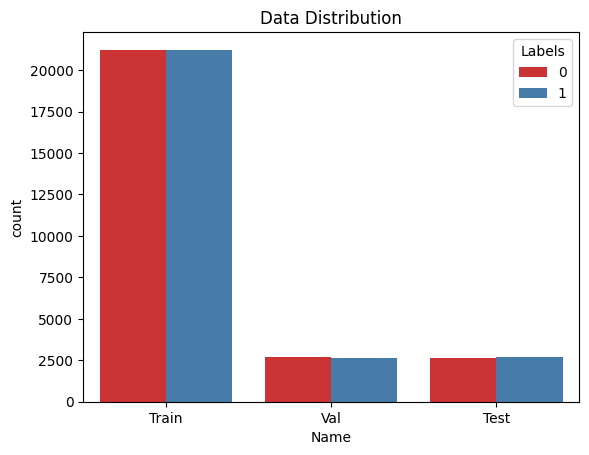

In [13]:
labels=[]
dataname=[]
for d in data:
    labels.extend((data[d])['label'])
    dataname.extend([d]*len(data[d].index))

label_distr=pd.DataFrame({'Labels':labels,'Name':dataname})
label_distr.reset_index() #resetting index to start from 0

sns.countplot(label_distr,x='Name',hue='Labels',palette='Set1')#reference: seaborn
plt.title('Data Distribution')
plt.show()

### Read Sequences

Extracting sequences for further computing of features.

In [14]:
sequences={}

for d in data:
    sequences[d]=(data[d])['sequence']

pd.DataFrame(sequences).head(5)

,Train,Val,Test
0,ACTAGAAAATCCTGGCATAGAGGTAACAGTCTTGAGAAGGGAGCCA...,CACATTTAGGAACTGAATGGATCCCCCAAAATTCATGTCAAACCCC...,TCATTCCCTGTCCTCGCGGATCTGCAGAGCACAGAGCAACCGCGAG...
1,TCCATTCTGCTACACTCCGGACGCCTGTTTAGGTTCAGGTTATATC...,TGTTCACAGACTGCGGGAAGCTTATGTCCTTGGCATCAGGATCCGG...,TTCTTTTTCCGGATTTTCAGCCGGGTCTTCCGGGGATGGAGAGCAA...
2,TTAATGGCAGCCAACAATTTTGTAGTTGTAAGTAACAGCGGAAAGG...,CTCACGCGCTGATTCCGGTTGAACCCAGGGGCTACCAATTAGCTGG...,GACATGGGCGAAGCACGCGAGCGGGGGTGGTCCCTTTCCATCGTGA...
3,ACACGTCTTGTAAGGCAGGCAAGCGAAGCTGCCAAGTTTTTGAATT...,TTTAACGGAATGGTTTTACATATCACGGGTATCCCAATCTGTCAAC...,TGTCGCGCCCTCCCGGGCTCGGCCACTCTGCCCTTCCCTGCCCCAG...
4,GACCGAATACGTCTAATGCGGAGCCGCATGCTTTAAGCACGATAGC...,CCTAAGAGGTTTGGCATATACCTTTCATAGAGAGGTTCTAGCTCAC...,CGGCCCTGCCTCTCTGCTTAACCAATGGCACGCCTCACTCCGTATG...


# Extract Features

From sequences extract each feature dataframe for further analysis.


## Basic Encodings

### One-Hot

<strong>What</strong>: Binary vector representing each nucleotide (e.g., A = [1,0,0,0]).

<strong>When to Use</strong>: Deep learning, where fixed input formats are needed.

<strong>Drawbacks</strong>: High dimensionality, ignores sequence context, no similarity captured.

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/OneHot.png?raw=1" alt="Description" width="500">
</div>

In [15]:
one_hot_feat=pd.DataFrame()
for seq_set in sequences:
    one_hot_feat=pd.concat([one_hot_feat,pd.DataFrame(one_hot_encode_sequences(sequences[seq_set]))],ignore_index=True)#for each set-> generates features and appends to the final dataset using concat function. Soruce of feature generating fucntion: basic_encoding
one_hot_feat.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,1,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
4,0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0


### K-mer

<strong>What</strong>: Counts frequency of subsequences of length k (e.g., all 3-mers in a DNA string).

<strong>When to Use</strong>: Feature engineering for ML models, sequence comparison.

<strong>Drawbacks</strong>: Loses global order, large k leads to sparse high-dimensional space.

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/Kmer.png?raw=1" alt="Description" width="500">
</div>

In [16]:
kmer_feat=pd.DataFrame()
for seq_set in sequences:
    kmer_feat=pd.concat([kmer_feat,pd.DataFrame(generate_kmer_features(sequences[seq_set],4))],ignore_index=True)#for each set-> generates features and appends to the final dataset using concat function. Soruce of feature generating fucntion: basic_encoding
kmer_feat.head(5)

,A,C,G,T,AA,AC,AG,AT,CA,CC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,0.273333,0.310000,0.276667,0.140000,0.076923,0.080268,0.090301,0.026756,0.100334,0.096990,...,0.003367,0.000000,0.003367,0.003367,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.200000,0.283333,0.236667,0.280000,0.040134,0.063545,0.056856,0.040134,0.060201,0.080268,...,0.000000,0.016835,0.006734,0.006734,0.003367,0.003367,0.006734,0.006734,0.006734,0.003367
2,0.260000,0.243333,0.280000,0.216667,0.093645,0.043478,0.080268,0.043478,0.060201,0.060201,...,0.000000,0.003367,0.003367,0.003367,0.003367,0.010101,0.003367,0.003367,0.006734,0.010101
3,0.296667,0.220000,0.193333,0.290000,0.090301,0.056856,0.070234,0.080268,0.063545,0.050167,...,0.006734,0.006734,0.003367,0.000000,0.006734,0.010101,0.010101,0.003367,0.006734,0.010101
4,0.246667,0.230000,0.286667,0.236667,0.066890,0.046823,0.076923,0.056856,0.060201,0.046823,...,0.003367,0.006734,0.000000,0.000000,0.003367,0.000000,0.006734,0.006734,0.000000,0.000000


## Numerical Mapping


### Integer

<strong>What</strong>: Encodes nucleotides as integers (e.g., A=0, C=1, G=2, T=3).

<strong>When to Use</strong>: Simple ML models, sequence alignment, indexing.

<strong>Drawbacks</strong>: Imposes false ordinal relationships; lacks biological meaning.

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/integer.png?raw=1" alt="Description" width="800">
</div>

In [17]:
integer_feat=pd.DataFrame()
for seq_set in sequences:
    integer_feat=pd.concat([integer_feat,pd.DataFrame(integer_features(sequences[seq_set],max_length))],ignore_index=True)#for each set-> generates features and appends to the final dataset using concat function. Soruce of feature generating fucntion: numerical_mapping
integer_feat.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,2,1,0,2,3,2,2,2,2,0,...,2,3,0,0,2,2,2,0,1,0
1,0,1,1,2,0,0,1,0,3,1,...,1,0,3,2,3,0,0,3,2,1
2,0,0,2,2,0,3,3,1,2,3,...,3,1,3,1,3,0,1,3,1,3
3,2,1,2,1,3,0,1,0,0,3,...,3,3,1,0,1,0,0,3,0,3
4,3,2,1,1,3,2,2,0,2,1,...,3,2,3,3,1,0,3,0,3,3


### Z-curve

<strong>What</strong>: 3D curve representation based on nucleotide distribution.

<strong>When to Use</strong>: Genome comparison, gene identification.

<strong>Drawbacks</strong>: Complex to compute and interpret; limited to certain applications.

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/Z-curve.png?raw=1" alt="Description" width="700">
</div>

In [18]:
zcurve_feat=pd.DataFrame()
for seq_set in sequences:
    zcurve_feat=pd.concat([zcurve_feat,pd.DataFrame(zcurve_features(sequences[seq_set],max_length))],ignore_index=True)#for each set-> generates features and appends to the final dataset using concat function. Soruce of feature generating fucntion: numerical_mapping
zcurve_feat.head(5)

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,1,0,-1,0,1,2,3,4,5,4,...,-57,-58,-57,-56,-55,-54,-53,-52,-53,-52
1,-1,-2,-3,-2,-3,-4,-5,-6,-5,-6,...,-13,-12,-13,-12,-13,-12,-11,-12,-11,-12
2,-1,-2,-1,0,-1,0,1,0,1,2,...,-7,-8,-9,-10,-11,-10,-11,-12,-13,-14
3,1,0,1,0,1,0,-1,-2,-3,-2,...,53,52,51,52,51,52,53,52,53,52
4,1,2,1,0,1,2,3,2,3,2,...,-7,-6,-7,-8,-9,-8,-9,-8,-9,-10


## Pysico-Chemical Features

### GC Content

<strong>What</strong>: Proportion of G and C nucleotides.

<strong>When to Use</strong>: Genome classification, stability prediction.

<strong>Drawbacks</strong>: Very coarse; ignores sequence order and context.

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/GC.png?raw=1" alt="Description" width="800">
</div>

In [19]:
gc_feat=pd.DataFrame()
for seq_set in sequences:
    gc_feat=pd.concat([gc_feat,pd.DataFrame(gc_content_features(sequences[seq_set]))],ignore_index=True)#for each set-> generates features and appends to the final dataset using concat function. Soruce of feature generating fucntion: physico_chemical
gc_feat.head(5)

,GC_Content,G_Count,C_Count,Length
0,0.586667,83,93,300
1,0.520000,71,85,300
2,0.523333,84,73,300
3,0.413333,58,66,300
4,0.516667,86,69,300


### Global Descriptors

<strong>What</strong>: Aggregated statistical features

<strong>When to Use</strong>: Classification tasks, especially in ML.

<strong>Drawbacks</strong>: May lose local sequence information; interpretation can be difficult.

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/GD.png?raw=1" alt="Description" width="500">
</div>

In [20]:
gd_feat=pd.DataFrame()
for seq_set in sequences:
    gd_feat=pd.concat([gd_feat,pd.DataFrame(global_descriptor_features(sequences[seq_set]))],ignore_index=True)#for each set-> generates features and appends to the final dataset using concat function. Soruce of feature generating fucntion: physico_chemical
gd_feat.head(5)

,Comp_A,Comp_C,Comp_G,Comp_T,Trans_AC,Trans_CT,Trans_TA,Trans_AG,Trans_GA,Trans_AA,...,Dist_G_0,Dist_G_1,Dist_G_2,Dist_G_3,Dist_G_4,Dist_T_0,Dist_T_1,Dist_T_2,Dist_T_3,Dist_T_4
0,0.273333,0.310000,0.276667,0.140000,0.080268,0.060201,0.026756,0.090301,0.066890,0.076923,...,0.013333,0.290000,0.600000,0.810000,0.970000,0.006667,0.206667,0.533333,0.823333,0.996667
1,0.200000,0.283333,0.236667,0.280000,0.063545,0.093645,0.043478,0.056856,0.056856,0.040134,...,0.026667,0.226667,0.460000,0.713333,0.990000,0.000000,0.256667,0.456667,0.730000,0.986667
2,0.260000,0.243333,0.280000,0.216667,0.043478,0.050167,0.043478,0.080268,0.063545,0.093645,...,0.016667,0.246667,0.493333,0.806667,0.996667,0.000000,0.263333,0.526667,0.723333,0.983333
3,0.296667,0.220000,0.193333,0.290000,0.056856,0.073579,0.093645,0.070234,0.046823,0.090301,...,0.013333,0.176667,0.486667,0.780000,0.996667,0.016667,0.333333,0.546667,0.753333,0.993333
4,0.246667,0.230000,0.286667,0.236667,0.046823,0.070234,0.036789,0.076923,0.083612,0.066890,...,0.000000,0.276667,0.610000,0.853333,0.996667,0.023333,0.300000,0.496667,0.756667,0.990000


## Advanced Representations

### Chaos Game Representation

<strong>What</strong>: Fractal-like image encoding sequence as 2D patterns.

<strong>When to Use</strong>: Visual pattern recognition, deep learning on images.

<strong>Drawbacks</strong>: Computationally heavy for long sequences; hard to interpret directly.

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/CGR.png?raw=1" alt="Description" width="500">
</div>


In [21]:
cgr_feat=pd.DataFrame()
for seq_set in sequences:
    cgr_feat=pd.concat([cgr_feat,pd.DataFrame(classifical_chaos_features(sequences[seq_set],max_length))],ignore_index=True)#for each set-> generates features and appends to the final dataset using concat function. Soruce of feature generating fucntion: CGR
cgr_feat.head(5)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.5,-0.25,-0.625,0.1875,0.59375,0.796875,0.898438,0.949219,0.974609,-0.012695,...,0.637743,-0.181129,0.409436,0.704718,0.852359,0.926179,0.963090,0.981545,-0.009228,0.495386
1,-0.5,-0.75,-0.875,0.0625,-0.46875,-0.734375,-0.867188,-0.933594,0.033203,-0.483398,...,-0.466787,0.266606,-0.366697,0.316652,-0.341674,0.329163,0.664581,-0.167709,0.416145,-0.291927
2,-0.5,-0.75,0.125,0.5625,-0.21875,0.390625,0.695312,-0.152344,0.423828,0.711914,...,-0.494849,-0.747424,-0.873712,-0.936856,-0.968428,0.015786,-0.492107,-0.746054,-0.873027,-0.936513
3,0.5,-0.25,0.375,-0.3125,0.34375,-0.328125,-0.664062,-0.832031,-0.916016,0.041992,...,-0.218478,-0.609239,-0.804620,0.097690,-0.451155,0.274423,0.637211,-0.181394,0.409303,-0.295349
4,0.5,0.75,-0.125,-0.5625,0.21875,0.609375,0.804688,-0.097656,0.451172,-0.274414,...,-0.734175,0.132912,-0.433544,-0.716772,-0.858386,0.070807,-0.464596,0.267702,-0.366149,-0.683075


# Univariate Analysis

- Load the feature dataframes one by one
- Run them through 4 different models
- Store all accuracies and get the boxplot for comparison

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/univar.png?raw=1" alt="Description" width="1000">
</div>

In [ ]:
feats=[one_hot_feat,kmer_feat,integer_feat,zcurve_feat,gc_feat,gd_feat,cgr_feat]
accuracy={}
feat_names=['One Hot','K-mer','Integer','Z-curve','GC','Global Desc','CGR']
for feat_ind in range(0,7):
    feat=(feats[feat_ind]).fillna(0)#replace any NaNs with 0
    train_feats=feat[label_distr['Name']=='Train']#extract train data
    test_feats=feat[label_distr['Name']=='Test']#extract train labels
    train_labels=label_distr[label_distr['Name']=='Train']['Labels']#extract test data
    test_labels=label_distr[label_distr['Name']=='Test']['Labels']#extract test labels
    accuracy[feat_names[feat_ind]]=run_models(train_feats,train_labels,test_feats,test_labels)#source of training function: ML_models

sns.boxplot(accuracy)
plt.title('Individual Feature Importance')
plt.show()


Training Models:  25%|██▌       | 1/4 [00:48<02:25, 48.38s/it]

# Multivariate Analysis

- Combine all features while dropping each feature one at a time
- Run them through 4 different models
- Store all accuracies and get the boxplot for comparison

<div style="text-align: center;">
  <img src="https://github.com/fabianagoes/ismb_tutorial8/blob/main/images/drop.png?raw=1" alt="Description" width="1000">
</div>

In [ ]:
feats=[one_hot_feat,kmer_feat,integer_feat,zcurve_feat,gc_feat,gd_feat,cgr_feat]
accuracy={}
feat_names=['One Hot','K-mer','Integer','Z-curve','GC','Global Desc','CGR']
for feat_ind in range(0,7):
    combined_feat_set=pd.concat(feats[:feat_ind] + feats[feat_ind+1:],axis=1)#combine feature dfs for all except current index
    combined_feat_set.columns=[i for i in range(0,len(combined_feat_set.keys()))]#rename columns to prevent duplicate keys
    combined_feat_set=combined_feat_set.fillna(0)#replace any NaNs with 0
    train_feats=combined_feat_set[label_distr['Name']=='Train']#extract train data
    test_feats=combined_feat_set[label_distr['Name']=='Test']#extract train labels
    train_labels=label_distr[label_distr['Name']=='Train']['Labels']#extract test data
    test_labels=label_distr[label_distr['Name']=='Test']['Labels']#extract test labels
    accuracy[feat_names[feat_ind]]=run_models(train_feats,train_labels,test_feats,test_labels)

sns.boxplot(accuracy)
plt.title('Effect of Dropping a Feature')
plt.show()


Training Models:   0%|                                                                   | 0/4 [00:00<?, ?it/s]

# Conclusions

#### Dataset 1 tested:
------------------------------

*Add findings here*

*-*

*-*

#### Dataset 2 tested:
------------------------------

*Add findings here*

*-*

*-*

#### Dataset 3 tested:
------------------------------

*Add findings here*

*-*

*-*